# CS246 - Colab 6
## node2vec

### Setup

In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

First of all, we install the [graph2vec library](https://github.com/VHRanger/graph2vec) which offers a fast implementation of the node2vec method.

If you are curious to learn how to implement fast random walks on graphs, I recommend you to [read the blog post](https://www.singlelunch.com/2019/08/01/700x-faster-node2vec-models-fastest-random-walks-on-a-graph/) which explains some of the design choices behind this library.

In [2]:
!pip install nodevectors

  Created wheel for nodevectors: filename=nodevectors-0.1.23-cp37-none-any.whl size=17960 sha256=9953aeff9a0002e669d269a2fddbb418eaca673f524ac23b2242fc2fed5d2aab
  Stored in directory: /root/.cache/pip/wheels/0b/5f/ef/684027a303aaba7555a4eb3e10107e3b304b748cf1a003ed27
  Created wheel for csrgraph: filename=csrgraph-0.1.28-cp37-none-any.whl size=17644 sha256=9876dd45dcc843542c0d2f192d3dad59cf7beb10fc591ad107004ef8477bd101
  Stored in directory: /root/.cache/pip/wheels/fa/c4/2f/43338df917189d06c668f320613b80e818dbec18bf7df7e05a
Successfully built nodevectors csrgraph


We now import the library, and create a small wrapper class which will expose only the few hyperparameters we will need to tune in this Colab

In [3]:
from nodevectors import Node2Vec
import networkx as nx

class Node2VecNew(Node2Vec):
  """
  Parameters
  ----------
  p : float
      p parameter of node2vec
  q : float
      q parameter of node2vec
  d : int
      dimensionality of the embedding vectors
  """
  def __init__(self, p=1, q=1, d=32):
    super().__init__(
                 n_components=d,
                     walklen=10,
                     epochs=50,
                     return_weight=1.0/p,
                     neighbor_weight=1.0/q,
                     threads=0,
                     w2vparams={'window': 4,
                                'negative': 5, 
                                'iter': 10,
                                'ns_exponent': 0.5,
                                'batch_words': 128})

Lastly, let's import some of the common libraries needed for our task.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Example

In the example below, we will try to reproduce the plot in slide 8 of [CS246 - Lecture 12](http://web.stanford.edu/class/cs246/slides/12-graphs2.pdf).

In [5]:
# Load the Zachary's Karate Club as a NetworkX Graph object
KCG = nx.karate_club_graph()

# Fit embedding model to the Karate Club graph
n2v = Node2VecNew(1, 1, 2)
n2v.fit(KCG)

Making walks... 

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Done, T=3.46
Mapping Walk Names... Done, T=0.05
Training W2V... Done, T=0.34


In [6]:
embeddings = []
for node in KCG.nodes:
  embedding = list(n2v.predict(node))
  club = KCG.nodes[node]['club']
  embeddings.append(embedding + [club])

# Construct a pandas dataframe with the 2D embeddings from node2vec,
# plus the club name that each node belongs to after the split
df = pd.DataFrame(embeddings, columns=['x', 'y', 'club'])

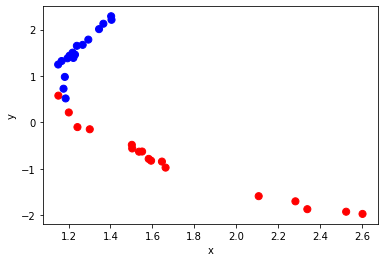

In [7]:
# Nodes who stayed with the Mr. Hi will be plotted in red, while nodes
# who moved with the Officer will be plotted in blue
colors = ['red' if x == 'Mr. Hi' else 'blue' for x in df.club]
df.plot.scatter(x='x', y='y', s=50, c=colors)

If our example trained correctly, you should notice a clear separation between the blue and red nodes.  Solely from the graph structure, node2vec could predict how the Zachary's Karate Club split!

Tune the hyperparameters ```p``` and ```q```, and notice how they affect the resulting embeddings.

### Your Task

Now we will study the behavior of node2vec on [barbell graphs](https://en.wikipedia.org/wiki/Barbell_graph).

Below you can see a toy example of a barbell graph generated with NetworkX.

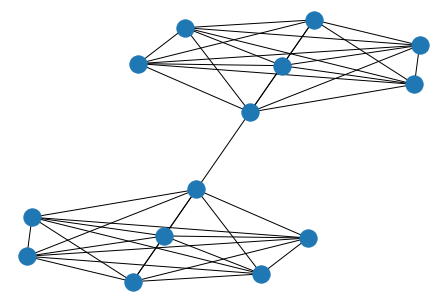

In [8]:
toy_barbell = nx.barbell_graph(7, 0)
nx.draw_kamada_kawai(toy_barbell)




Generate a larger barbell graph, where each complete graph has exactly 1000 nodes, and the path length between the complete graphs is equal to 1 (i.e., all the nodes in the barbell graph belong to either one of the two complete graphs, and the connecting path does not have any internal node).

Then, learn node2vec embeddings on this graph, setting ```p = 1, q = 1``` and ```d = 10```.

In [9]:
barbell1 = nx.barbell_graph(1000, 0)

In [10]:
nx.info(barbell1)

'Name: \nType: Graph\nNumber of nodes: 2000\nNumber of edges: 999001\nAverage degree: 999.0010'

In [11]:
barbell1_model = Node2VecNew(1, 1, 10)
barbell1_model.fit(barbell1)

Making walks... Done, T=0.50
Mapping Walk Names... Done, T=1.47
Training W2V... Done, T=27.90


In [12]:
embeddings1 = []
for node in barbell1.nodes:
  embedding = list(barbell1_model.predict(node))
  embeddings1.append(embedding)

In [13]:
from scipy import spatial

Write a function that takes as input a node id ```n``` in the graph (e.g., ```5```) and returns a list containing the cosine similarity between the node2vec vector of the input node ```n``` and all the nodes in the given barbell graph (including the similarity with ```n``` itself).

In [18]:
def cos_sim(id1, barbell_graph, embeddings):
  cos_sim = []
  node1 = embeddings[id1]
  for id2 in list(barbell_graph.nodes):
    node2 = embeddings[id2]
    result = 1 - spatial.distance.cosine(node1, node2)
    if result > 0.8:
      cos_sim.append((id1, result))
  return cos_sim

In [19]:
res = []
for node in list(barbell1.nodes):
  c = cos_sim(node, barbell1, embeddings1)
  res.append(c)

In [20]:
count = 0
for id in range(len(res)):
  if len(res[id]) == 1000:
    count += 1

In [21]:
count

2000

Generate another barbell graph, this time adding a path of length 51 between the two complete graphs. To find out how, refer to the NetworkX documentation: [https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.classic.barbell_graph.html#networkx.generators.classic.barbell_graph](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.classic.barbell_graph.html#networkx.generators.classic.barbell_graph)

Learn the node2vec embeddings for the nodes of this new graph, using the same hyperparameters as before.

In [22]:
barbell2 = nx.barbell_graph(1000, 50)

In [23]:
nx.info(barbell2)

'Name: \nType: Graph\nNumber of nodes: 2050\nNumber of edges: 999051\nAverage degree: 974.6839'

In [24]:
barbell2_model = Node2VecNew(1, 1, 10)
barbell2_model.fit(barbell2)

Making walks... Done, T=0.50
Mapping Walk Names... Done, T=1.14
Training W2V... Done, T=26.77


In [25]:
embeddings2 = []
for node in barbell2.nodes:
  embedding = list(barbell2_model.predict(node))
  embeddings2.append(embedding)

In [26]:
res2 = []
for node in list(barbell2.nodes):
  c = cos_sim(node, barbell2, embeddings2)
  res2.append(c)

In [28]:
count2 = 0
for id in range(len(res2)):
  if len(res2[id]) == 1000:
    count2 += 1

In [30]:
count2

0

In [32]:
count3 = 0
for id in range(len(res2)):
  if len(res2[id]) < 100:
    count3 += 1

In [33]:
count3

52

Once you have working code for each cell above, **head over to Gradescope, read carefully the questions, and submit your solution for this Colab**!


---
---
# Results:
---
---
*   Q2.1: 2000
*   Q2.2: 999001
---
*   Q3.1: 2050
*   Q3.2: 999051
---
*   Q4.1: 2000
*   Q4.2: 0
*   Q4.3: [0, 100)
